In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
from datetime import datetime
import os,sys
import  joblib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
import tensorflow as tf
from keras.layers import (
    Input,
    LSTM,
    Dropout,
    Dense
)
from keras.models import (
    Model,
    Sequential,
    load_model
)
from tensorflow.keras.callbacks import (
    Callback,
    TensorBoard,
    EarlyStopping
)

In [4]:
def locate_input_file(input_file_name="gold_price_2013_2023.csv"):
    try:
        dir_name=os.getcwd()
        input_file_path=os.path.join(dir_name,input_file_name)
        # print(input_file_path)
        return input_file_path
    
    except Exception as e:
        print(f"error : {e}")

In [5]:
def get_input_data(file_path):
    
    try:
        df=pd.read_csv(file_path)
        return df
    
    except Exception as e:
        print(f"error : {e}")



In [6]:
def print_details(df):
    try:
        print(f"shape of df : {df.shape}\n")
        print(f"columns of df : {df.columns}\n\n")
        print(f"information about df : \n{df.info()}\n\n")
        print(f"description about df : \n{df.describe()}\n\n")
        print(f"head of df : \n{df.head()}\n\n")
        print(f"tail of df : \n{df.tail()}\n\n")

        # for col in df.columns:    
        #     print(f"value count of df : \n {df[col].value_counts()}")    

    except Exception as e:
        print(f"error : {e}")

In [7]:
def remove_unwanted_columns(df,unwanted_columns):
    try:
        # unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        unwanted_count=len(unwanted_columns)
        # print(unwanted_count)
        temp_count=0
        for col in unwanted_columns:
            if col in df.columns:
                temp_count+=1

        
        if temp_count==unwanted_count :
            print(f"all unwanted columns can be removed.")
        else:
            print(f"all unwanted columns can not be removed.")

        df=df.drop(columns=unwanted_columns,axis=1)

        return df
    
    except Exception as e:
        print(f"error : {e}")

In [8]:
def sort_date(df):
    try:
        df.sort_values(
            by=["Date"],
            axis=0,
            ascending=True,
            inplace=True
        )
        # print(f"first 5 data : \n{df[:5]}")
        # print(f"last 5 data : \n{df[-5:]}")
        return df

    except Exception as e:
        print(f"error : {e}")

In [9]:
def clean_data(df,dir_name):
    try:
        df["Date"]=pd.to_datetime(df["Date"])
        df["Price"]=df["Price"].str.replace(",","").astype(float)
        df=sort_date(df)

        scaler=MinMaxScaler()
        df["Price"]=scaler.fit_transform(df[["Price"]])

        file_dir=os.path.join(os.getcwd(),"scaler")
        file_name=f"price_MinMaxScaler_{dir_name}.pkl"
        file_path=os.path.join(file_dir,file_name)

        os.makedirs(
            file_dir,
            exist_ok=True
        )

        joblib.dump(
            scaler,
            file_path
        )

        return df

    except Exception as e:
        print(f"error : {e}")

In [10]:
def handle_missing(df):
    try:
        print(f"Column-wise missing values:\n{df.isnull().sum()}\n")
        print(f"Total missing values: {df.isnull().sum().sum()}\n")

        num_cols = df.select_dtypes(include=["int64", "float64"]).columns
        cat_cols = df.select_dtypes(include="object").columns

        print(f"Numerical columns: {list(num_cols)}")
        print(f"Categorical columns: {list(cat_cols)}")

        # Fill missing values
        for col in num_cols:
            df[col] = df[col].fillna(df[col].mean())

        for col in cat_cols:
            df[col] = df[col].fillna(df[col].mode()[0])

        return df

    except Exception as e:
        print("Error:", e)


In [11]:
def handle_duplicate(df):
    try:
        duplicate_count=df.duplicated().sum()
        print(f"duplicated  values : {duplicate_count}")
        
        if duplicate_count>0:
            df.drop_duplicates(ignore_index=True)

        return df

    except Exception as e:
        print(e)

In [12]:
def plot_figure(df):
    try:
        print("you are in plot figure")
        test_size=df[df["Date"].dt.year==2022].shape[0]
            
        plt.figure(
            figsize=(15,6),
            dpi=150
        )
        plt.rcParams["axes.facecolor"] = "pink"
        plt.rcParams["axes.edgecolor"] = "white"
        
        plt.plot(
            df["Date"][:-test_size],
            df["Price"][:-test_size],
            color="blue",
            lw=2        
        )
        plt.plot(
            df["Date"][-test_size:],
            df["Price"][-test_size:],
            color="yellow",
            lw=2
        )
        plt.title("gold price",fontsize=36)
        plt.xlabel("Date",fontsize=12)
        plt.ylabel("Price",fontsize=12)
        plt.legend(
            [
                "Training set",
                "Test set"
            ],
            loc="upper left",
            prop={"size":15}
        )
        plt.grid(color="white")
        plt.show()

    except Exception as e:
        print(f"error  : {e}")

In [13]:
def build_train_test_dataset(df,test_size,window):
    try:
        train_data=df["Price"][:-test_size].to_numpy().reshape(-1,1)
        x_train=[]
        y_train=[]

        for i in range(window,len(train_data)):
            x_train.append(train_data[i-window:i,0])
            y_train.append(train_data[i,0])


        x_train=np.array(x_train)
        y_train=np.array(y_train)

        print(f"x_train shape :{x_train.shape}")
        print(f"y_train shape :{y_train.shape}")


        
        test_data=df["Price"][-test_size-window:].to_numpy().reshape(-1,1)
        x_test=[]
        y_test=[]

        for i in range(window,len(test_data)):
            x_test.append(test_data[i-window:i,0])
            y_test.append(test_data[i,0])

        x_test=np.array(x_test)
        y_test=np.array(y_test)


        print(f"x_test shape :{x_test.shape}")
        print(f"y_test shape :{y_test.shape}")


        return x_train,y_train,x_test,y_test

    except Exception as e:
        print(f"error : {e}")

In [14]:
def get_recent_log_dir():
    try:
        log_path = os.path.join(os.getcwd(), "log","fit")
        log_files = sorted(os.listdir(log_path))
        return os.path.join(log_path, log_files[-1])

    except Exception as e:
        print(f"error : {e}")

def launch_tensorboard():
    try:
        ipython = get_ipython()

        # Load or reload the extension
        try:
            ipython.run_line_magic('reload_ext', 'tensorboard')
        except:
            ipython.run_line_magic('load_ext', 'tensorboard')

        # Get latest log directory
        log_dir = get_recent_log_dir()
        print("Launching TensorBoard at:", log_dir)

        # Start TensorBoard
        ipython.run_line_magic('tensorboard', f'--logdir "{log_dir}"')

    except Exception as e:
        print(f"error : {e}")

In [15]:
def get_tensorboard_callback():
    try:
        tensor_file_name=datetime.now().strftime("%d_%m_%y__%H_%M_%S")
        log_file= "log"

        log_path=os.path.join(os.getcwd(),log_file,"fit",tensor_file_name)
        dir_name=os.path.dirname(log_path)
        
        os.makedirs(
            dir_name,
            exist_ok=True
        )

        # return TensorBoard(
        #         log_dir=log_path,
        #         histogram_freq=1
        # )


        return TensorBoard(
            log_dir=log_path,
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            profile_batch=0  # Set to 0 or specific batch index for profiling
        )
    
    except Exception as e:
        print(f"error : {e}")

In [16]:
def get_early_stopping_callback():
    try :
        early_stopping_callback=EarlyStopping(
            monitor="val_loss",
            patience=100,
            restore_best_weights=True,
        )
        return  early_stopping_callback

    except Exception as e:
        print(f"error : {e}")

In [17]:
def build_lstm_model(window):
    try:
        model_units=0
        if window < 100 :
            model_units = 120
        else :
            model_units = window

        input1=Input(shape=(window,1))
        x=LSTM( 
            units=model_units,
            return_sequences=True
        )(input1)
        x=Dropout(0.2)(x)
        x=LSTM(
            units=model_units,
            return_sequences=True
        )(x)
        x=Dropout(0.2)(x)
        x=LSTM(
            units=model_units,
            return_sequences=False
        )(x)
        x=Dropout(0.2)(x)
        x=Dense(
            units=int(model_units/2),
            activation="relu"
        )(x)
        x=Dense(
            units=int(model_units/4),
            activation="relu"
        )(x)
        dnn_output=Dense(1)(x)


        model=Model(
            inputs=input1,
            outputs=[dnn_output]
        )
        # model.compile(
        #     loss="mean_squared_error",
        #     optimizer="Nadam"
        # )

        print(f"returning model.")
        model.summary()

        return model
    

    except Exception as e:
        print(f"build_model error : e")
        return None

In [18]:
def compile_model(model):
    try:
        model.compile(
            optimizer="adam",
            loss="mae",
            metrics=["mae","mse"]
        )

        return model

    except Exception as e:
        print("error : {e}")

In [37]:
def run_model(model,x_train,y_train,epochs,window):
    try:
        start_time=datetime.now()
        history=model.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=window*5,
            validation_split=0.2,
            verbose=1,
            callbacks=[
                # get_tensorboard_callback(),
                get_early_stopping_callback()
            ]
        )
        end_time=datetime.now()

        print(f"time taken to run the model : {end_time - start_time}")

        return history

    except Exception as e:
        print(f"error : {e}")

In [20]:
# def evaluate_history(history):
#     try:
#         history_data = history.history
#         keys = list(history_data.keys())

#         plt.figure(figsize=(10, 6))
#         plt.title("Model Training Metrics")
#         plt.xlabel("Epoch")
#         plt.ylabel("Metric Value")

#         for key in keys:
#             plt.plot(history_data[key], label=key)

#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     except Exception as e:
#         print(f"History evaluation error: {e}")


In [21]:
def show_history(history):
    try:
        history_data = history.history
        keys = list(history_data.keys())
        
        validation_keys=[k for k in keys if k.startswith("val_")]
        training_keys=[k for k in keys if not k.startswith("val_") ]

        # for key in keys:
        #     plt.figure(figsize=(5, 3))
        #     plt.xlabel("Epoch")
        #     plt.ylabel(f"{key}")
        #     plt.plot(history_data[key], label=key)
        #     plt.legend()
        #     plt.grid(True)
        #     plt.tight_layout()
        #     plt.show()

        for key1,key2 in zip(training_keys,validation_keys):
            plt.figure(figsize=(5, 3))
            plt.xlabel("Epoch")
            # plt.ylabel(f"{key}")
            plt.plot(history_data[key1], label=key1)
            plt.plot(history_data[key2], label=key2)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [22]:
# 

In [23]:
def save_history_csv(history, file_path):
    try:
        df = pd.DataFrame(history.history)
        df.to_csv(file_path, index=False)
        
        print(f"History saved as CSV at {file_path}")
    except Exception as e:
        print(f"Error saving history as CSV: {e}")


In [24]:
def history_details(history):
    try:
        file_name=datetime.now().strftime("history%d_%m_%y__%Hh_%Mm_%Ss")+".csv"
        file_path=os.path.join(os.getcwd(),"history",file_name)
        file_dir=os.path.dirname(file_path)
        os.makedirs(
            file_dir,
            exist_ok=True
        )

        save_history_csv(history,file_path)
        show_history(history)
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [25]:
def history_details1(history,file_dir,window):
    try:
        file_name=f"history_{window}_.csv"
        file_path=os.path.join(os.getcwd(),"history",file_dir,file_name)
        file_dir=os.path.dirname(file_path)
        
        os.makedirs(
            file_dir,
            exist_ok=True
        )

        save_history_csv(history,file_path)
        show_history(history)
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [26]:
def evaluate_model():
    try:
        # evaluate_history()
        launch_tensorboard()

    except Exception as e:
        print(f"error : {e}")

In [27]:
def run_training():
    try:
        input_file_path=locate_input_file()
        print(input_file_path)  


        df=get_input_data(input_file_path)
        print_details(df)

        unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        df=remove_unwanted_columns(df,unwanted_columns)
        print_details(df)

        df=clean_data(df)
        print(df.head())
        print(df.tail())
        

        df=handle_missing(df)

        df=handle_duplicate(df)

        plot_figure(df)


        test_size=df[df["Date"].dt.year==2022].shape[0]
        window=60

        print(test_size,window)


        x_train,y_train,x_test,y_test=build_train_test_dataset(
            df,
            test_size,
            window
        )

        model=build_lstm_model(window)

        model=compile_model(model)

        model_file_name=f"model_{window}_.keras"
        model.save(model_file_name)

        epochs=50

        history=run_model(
            model,
            x_train,
            y_train,
            epochs
        )

        history_details(history)

        evaluate_model()




    except Exception as e:
        print(f"error : {e}")

In [28]:
# run_training()

In [29]:
def test_training():
    try:
        input_file_path=locate_input_file()
        print(input_file_path)  


        df=get_input_data(input_file_path)
        print_details(df)

        unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        df=remove_unwanted_columns(df,unwanted_columns)
        print_details(df)

        df=clean_data(df)
        print(df.head())
        print(df.tail())
        

        df=handle_missing(df)

        df=handle_duplicate(df)

        plot_figure(df)


        test_size=df[df["Date"].dt.year==2022].shape[0]
        window=60

        print(test_size,window)


        x_train,y_train,x_test,y_test=build_train_test_dataset(
            df,
            test_size,
            window
        )

        # model=build_lstm_model(window)

        # model=compile_model(model)

        # model_file_name=f"model_{window}_.h5"
        # model.save(model_file_name)

        # epochs=50

        # history=run_model(
        #     model,
        #     x_train,
        #     y_train,
        #     epochs
        # )

        # history_details(history)

        # evaluate_model()




    except Exception as e:
        print(f"error : {e}")

In [41]:
def build_model_pipeline():
    try:
        
        dir_name=datetime.now().strftime("%d_%m_%y__%Hh_%Mm_%Ss")

        input_file_path = locate_input_file()
        print(input_file_path)

        df = get_input_data(input_file_path)
        # print_details(df)

        unwanted_columns = ['Open', 'High', 'Low', 'Vol.', 'Change %']
        df = remove_unwanted_columns(df, unwanted_columns)
        print_details(df)

        df = clean_data(df,dir_name)
        print(f"df type : {type(df)}")
        print(df.head())
        print(df.tail())

        df = handle_missing(df)
        df = handle_duplicate(df)

        plot_figure(df)

        test_size = df[df["Date"].dt.year == 2022].shape[0]

        windows = [5, 20, 60, 120, 240]
        epochs = 10
        testing_data = []
        real_data = []

        dir_name=datetime.now().strftime("%d_%m_%y__%Hh_%Mm_%Ss")
        history_file_dir=f"history_{dir_name}__epochs_{epochs}"
        model_file_dir=f"model_{dir_name}__epochs_{epochs}"

        for window in windows:
            x_train, y_train, x_test, y_test = build_train_test_dataset(
                df,
                test_size,
                window
            )
            testing_data.append(x_test[0])
            real_data.append(y_test[0])

            model = build_lstm_model(window) 
            model = compile_model(model)

            history = run_model(
                model,
                x_train,
                y_train,
                epochs=epochs,
                window=window
            )

            history_details1(history,history_file_dir,window)

            model_file_dir=os.path.join(os.getcwd(),"models",model_file_dir)
            model_file_name = f"model_{window}_.keras"
            model_file_path=os.path.join(model_file_dir,model_file_name)
            os.makedirs(
                model_file_dir,
                exist_ok=True
            )

            model.save(model_file_path)

        # for data in testing_data:
        #     print(data)

        # for data in real_data:
        #     print(data)

    except Exception as e:
        print(f"error: {e}")


e:\data_science_play_ground\gold_price_prediction\gold_price_2013_2023.csv
all unwanted columns can be removed.
shape of df : (2583, 2)

columns of df : Index(['Date', 'Price'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2583 non-null   object
 1   Price   2583 non-null   object
dtypes: object(2)
memory usage: 40.5+ KB
information about df : 
None


description about df : 
              Date     Price
count         2583      2583
unique        2583      2072
top     12/30/2022  1,294.30
freq             1         5


head of df : 
         Date     Price
0  12/30/2022  1,826.20
1  12/29/2022  1,826.00
2  12/28/2022  1,815.80
3  12/27/2022  1,823.10
4  12/26/2022  1,809.70


tail of df : 
            Date     Price
2578  01/08/2013  1,663.20
2579  01/07/2013  1,647.20
2580  01/04/2013  1,649.90
2581  01/03/2013  1,675.60
25

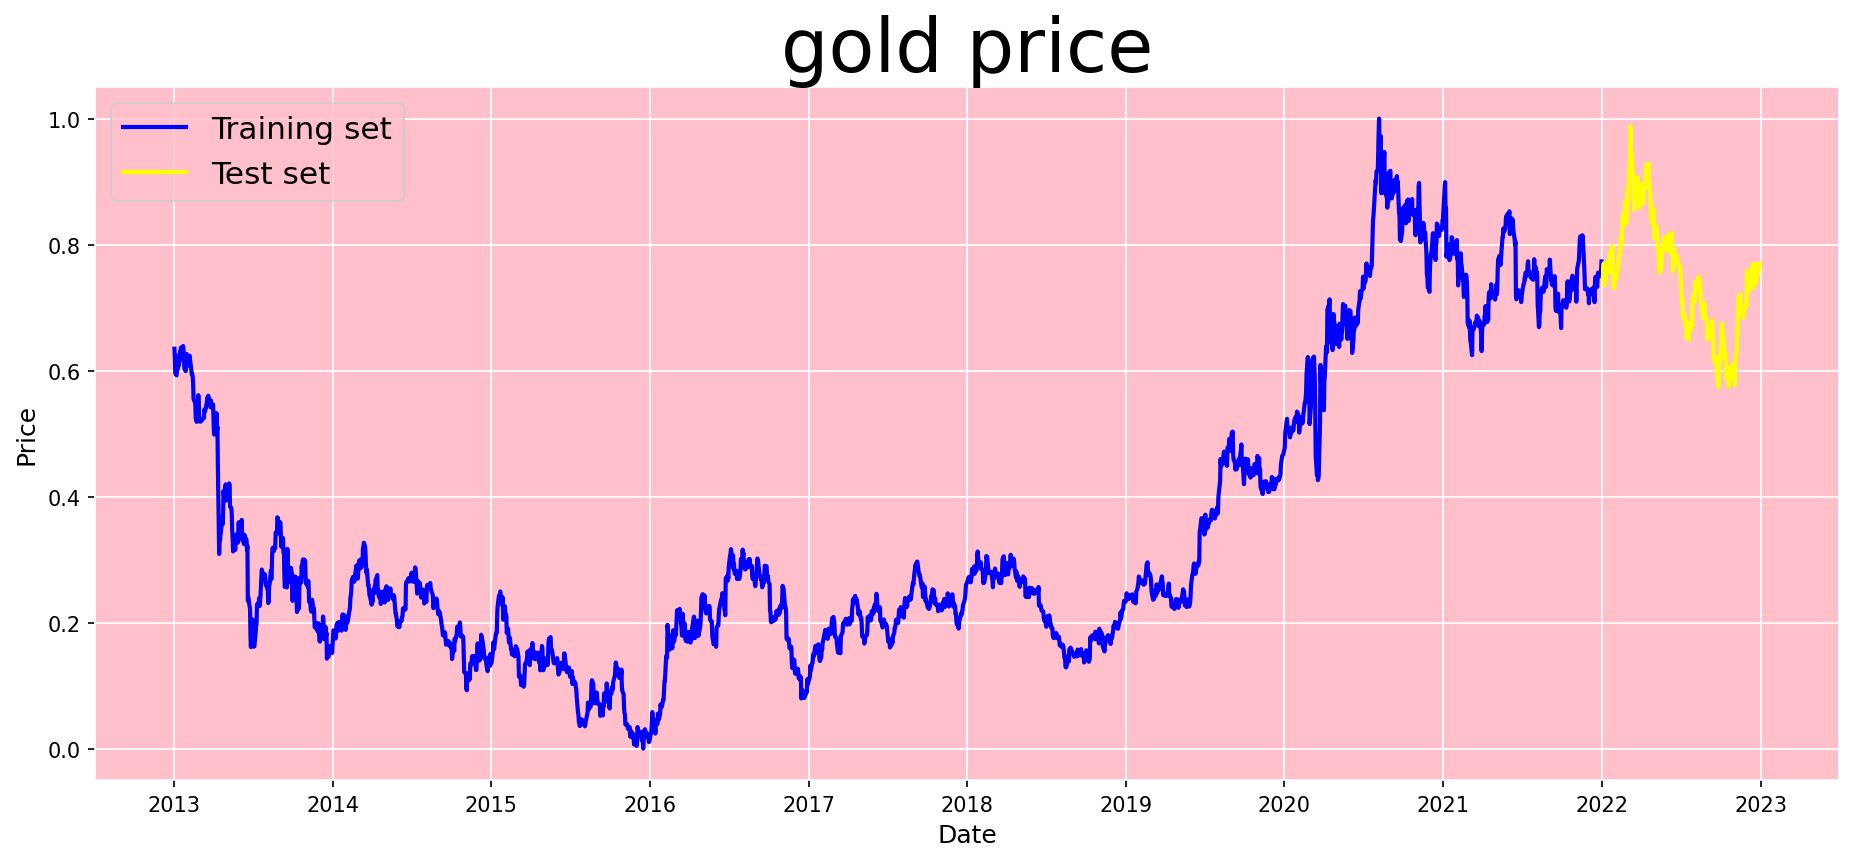

x_train shape :(2318, 5)
y_train shape :(2318,)
x_test shape :(260, 5)
y_test shape :(260,)
returning model.


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 5, 120)         │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 5, 120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 5, 120)         │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 5, 120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 120)            │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,041 (1.14 MB)

 Trainable params: 299,041 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0554 - mae: 0.0554 - mse: 0.0081 - val_loss: 0.0269 - val_mae: 0.0269 - val_mse: 0.0014
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0010 - val_loss: 0.0612 - val_mae: 0.0612 - val_mse: 0.0046
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0206 - mae: 0.0206 - mse: 7.7963e-04 - val_loss: 0.0430 - val_mae: 0.0430 - val_mse: 0.0025
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186 - mae: 0.0186 - mse: 6.5119e-04 - val_loss: 0.0730 - val_mae: 0.0730 - val_mse: 0.0063
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194 - mae: 0.0194 - mse: 6.7797e-04 - val_loss: 0.0238 - val_mae: 0.0238 - val_mse: 0.0011
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0197 - mae: 0.0197 - mse: 6.8452e-04 - val_loss: 0.0583 - val_mae: 0.0583 - val_mse: 0.0042
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0204 - mae: 0.0204 - mse: 7.6645e-0

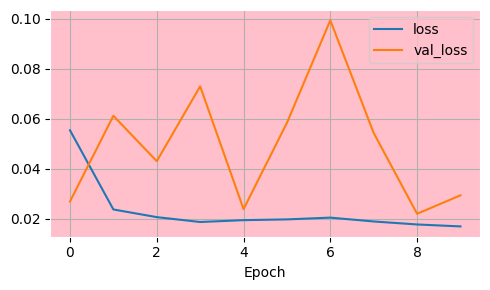

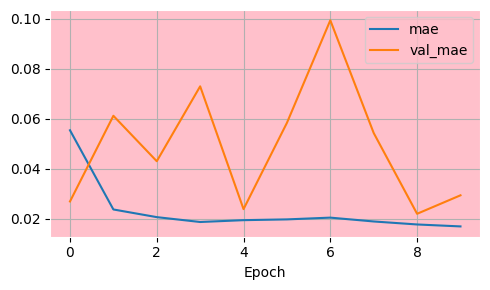

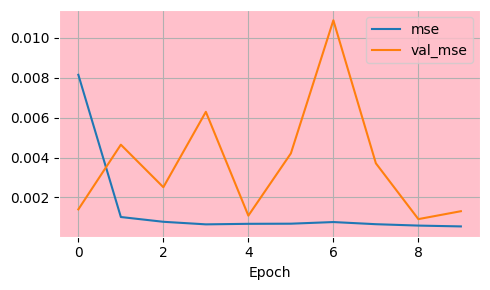

x_train shape :(2303, 20)
y_train shape :(2303,)
x_test shape :(260, 20)
y_test shape :(260,)
returning model.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 20, 120)        │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 20, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 20, 120)        │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 20, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 120)            │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,041 (1.14 MB)

 Trainable params: 299,041 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0872 - mae: 0.0872 - mse: 0.0150 - val_loss: 0.2542 - val_mae: 0.2542 - val_mse: 0.0671
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0353 - mae: 0.0353 - mse: 0.0022 - val_loss: 0.0363 - val_mae: 0.0363 - val_mse: 0.0023
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0297 - mae: 0.0297 - mse: 0.0016 - val_loss: 0.0543 - val_mae: 0.0543 - val_mse: 0.0043
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0287 - mae: 0.0287 - mse: 0.0015 - val_loss: 0.0528 - val_mae: 0.0528 - val_mse: 0.0040
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0266 - mae: 0.0266 - mse: 0.0013 - val_loss: 0.0392 - val_mae: 0.0392 - val_mse: 0.0024
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0261 - mae: 0.0261 - mse: 0.0012 - val_loss: 0.0314 - val_mae: 0.0314 - val_mse: 0.0018
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0278 - mae: 0.0278 - mse: 0.0014 - val_loss: 

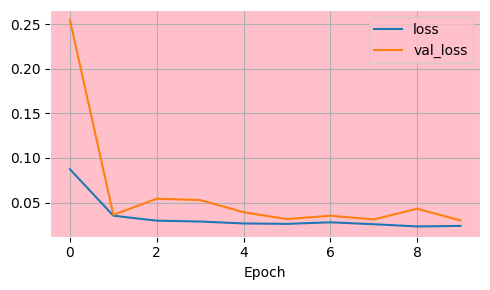

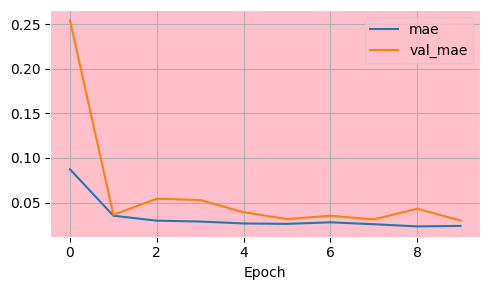

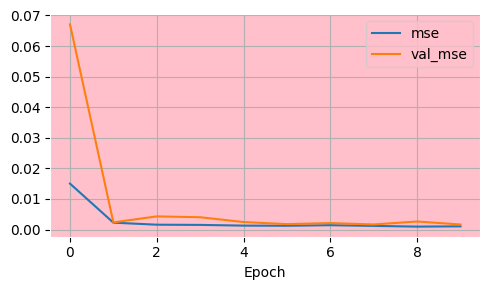

x_train shape :(2263, 60)
y_train shape :(2263,)
x_test shape :(260, 60)
y_test shape :(260,)
returning model.


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 60, 120)        │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 120)        │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 120)            │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,041 (1.14 MB)

 Trainable params: 299,041 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 419ms/step - loss: 0.1510 - mae: 0.1510 - mse: 0.0327 - val_loss: 0.3973 - val_mae: 0.3973 - val_mse: 0.1608
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - loss: 0.0881 - mae: 0.0881 - mse: 0.0125 - val_loss: 0.2694 - val_mae: 0.2694 - val_mse: 0.0753
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - loss: 0.0578 - mae: 0.0578 - mse: 0.0051 - val_loss: 0.3692 - val_mae: 0.3692 - val_mse: 0.1393
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - loss: 0.0579 - mae: 0.0579 - mse: 0.0063 - val_loss: 0.1402 - val_mae: 0.1402 - val_mse: 0.0217
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - loss: 0.0455 - mae: 0.0455 - mse: 0.0033 - val_loss: 0.1376 - val_mae: 0.1376 - val_mse: 0.0208
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - loss: 0.0335 - mae: 0.0335 - mse: 0.0020 - val_loss: 0.0471 - val_mae: 0.0471 - val_mse: 0.0035
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - loss: 0.0320 - mae: 0.0320 - mse: 0.0018 - val_loss: 0.0482 

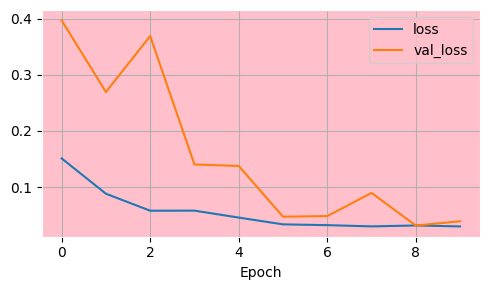

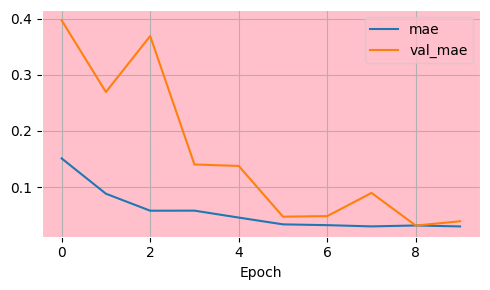

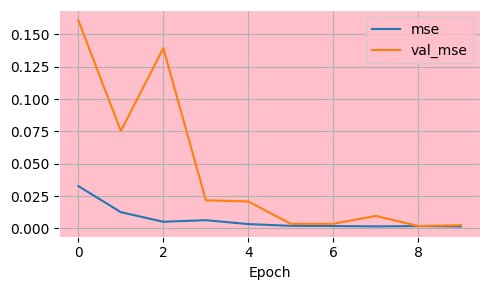

x_train shape :(2203, 120)
y_train shape :(2203,)
x_test shape :(260, 120)
y_test shape :(260,)
returning model.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 120, 120)       │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 120, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 120, 120)       │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 120, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 120)            │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,041 (1.14 MB)

 Trainable params: 299,041 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 0.1613 - mae: 0.1613 - mse: 0.0379 - val_loss: 0.0375 - val_mae: 0.0375 - val_mse: 0.0025
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 0.0696 - mae: 0.0696 - mse: 0.0072 - val_loss: 0.3382 - val_mae: 0.3382 - val_mse: 0.1171
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0578 - mae: 0.0578 - mse: 0.0064 - val_loss: 0.1991 - val_mae: 0.1991 - val_mse: 0.0420
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 0.0495 - mae: 0.0495 - mse: 0.0037 - val_loss: 0.1675 - val_mae: 0.1675 - val_mse: 0.0302
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 0.0422 - mae: 0.0422 - mse: 0.0033 - val_loss: 0.2271 - val_mae: 0.2271 - val_mse: 0.0537
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 0.0385 - mae: 0.0385 - mse: 0.0028 - val_loss: 0.0455 - val_mae: 0.0455 - val_mse: 0.0033
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - loss: 0.0353 - mae: 0.0353 - mse: 0.0021 - val_loss: 0.0948 - val_mae: 0.0

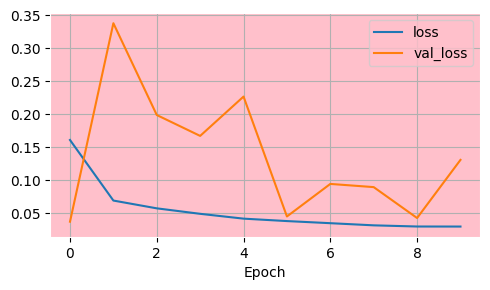

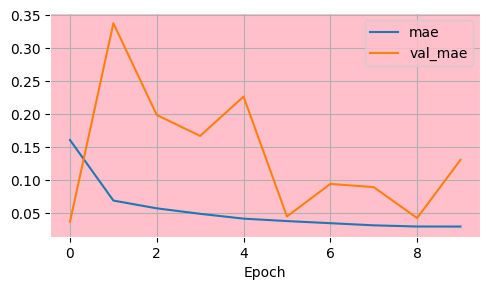

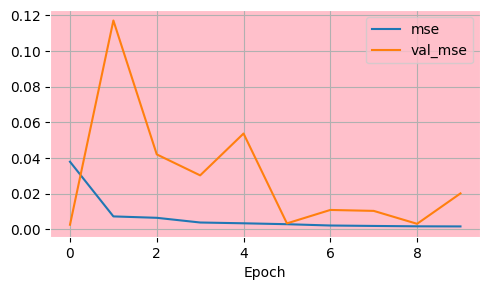

x_train shape :(2083, 240)
y_train shape :(2083,)
x_test shape :(260, 240)
y_test shape :(260,)
returning model.


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 240, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 240, 240)       │       232,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 240, 240)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 240, 240)       │       461,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 240, 240)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 240)            │       461,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 120)            │        28,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,081 (4.55 MB)

 Trainable params: 1,192,081 (4.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 90s 30s/step - loss: 0.2257 - mae: 0.2257 - mse: 0.0662 - val_loss: 0.3317 - val_mae: 0.3317 - val_mse: 0.1130
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 28s/step - loss: 0.1630 - mae: 0.1630 - mse: 0.0531 - val_loss: 0.0461 - val_mae: 0.0461 - val_mse: 0.0037
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 18s/step - loss: 0.0787 - mae: 0.0787 - mse: 0.0091 - val_loss: 0.5307 - val_mae: 0.5307 - val_mse: 0.2852
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 93s 38s/step - loss: 0.1325 - mae: 0.1325 - mse: 0.0266 - val_loss: 0.5245 - val_mae: 0.5245 - val_mse: 0.2786
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 26s/step - loss: 0.1166 - mae: 0.1166 - mse: 0.0222 - val_loss: 0.3846 - val_mae: 0.3846 - val_mse: 0.1510
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 27s/step - loss: 0.0653 - mae: 0.0653 - mse: 0.0088 - val_loss: 0.1062 - val_mae: 0.1062 - val_mse: 0.0137
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 26s/step - loss: 0.0853 - mae: 0.0853 - mse: 0.0091 - val_loss: 0.2449 - val_m

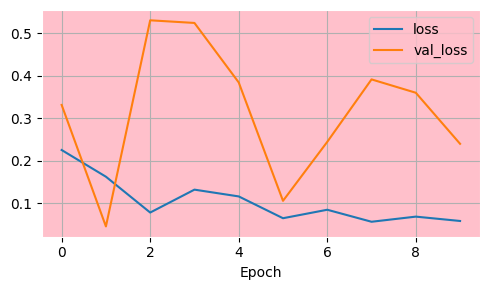

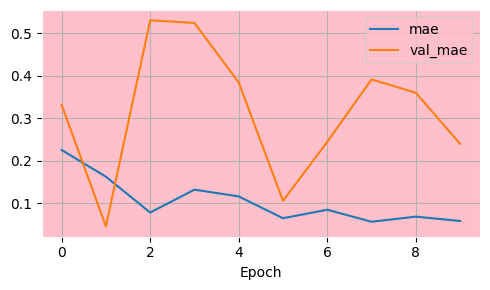

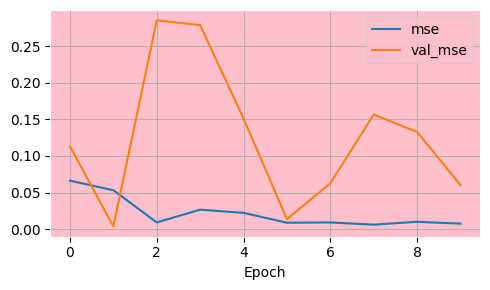

In [42]:
build_model_pipeline()

In [32]:
# windows=[5,20,60,120,240]
# epochs=10
# testing_data=[]
# real_data=[]

# for window in windows:
#     x_train,y_train,x_test,y_test=build_train_test_dataset(
#         df,
#         test_size,
#         window
#     )
#     testing_data.append(x_test[0])
#     real_data.append(y_test[0])

#     model=build_model(window)
#     model=compile_model(model)

#     history=run_model(
#         model,
#         x_train,
#         y_train,
#         epochs=10
#     )

#     model_file_name=f"model_{window}_.h5"
#     model.save(model_file_name)


# for data in testing_data:
#     print(data)

# for data in real_data:
#     print(data)

In [33]:
        #  df['Close'] ──► [LSTM: window=6] ─┐
        #                    prediction_6   │
        #  df['Close'] ──► [LSTM: window=20] ─┐
        #                    prediction_20   │
        #  df['Close'] ──► [LSTM: window=60] ─┐
        #                    prediction_60   │
        #  df['Close'] ──► [LSTM: window=120] ─┐
        #                    prediction_120   │──► [Sequential Meta Model] ─► Final Output
        #  df['Close'] ──► [LSTM: window=240] ─┘
        #                    prediction_240


In [34]:
# windows = [5, 20, 60, 120, 240]
# meta_inputs = []
# real_outputs = None  # will be set once

# for window in windows:
#     model = load_model(f"lstm_window_{window}.h5")
#     x_train, y_train, x_test, y_test = build_train_test_dataset(df, test_size, window)

#     preds = model.predict(x_test)
#     meta_inputs.append(preds.reshape(-1, 1))  # reshape to column

#     if real_outputs is None:
#         real_outputs = y_test  # assuming all y_test are aligned

# # Stack predictions horizontally
# X_meta = np.hstack(meta_inputs)  # shape: (samples, 5)
# y_meta = real_outputs


In [35]:
# def build_meta_model(input_dim=5):
#     model = Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))  # Predict final price
#     model.compile(optimizer='adam', loss='mse')
#     return model

# meta_model = build_meta_model()
# meta_model.fit(X_meta, y_meta, epochs=10, batch_size=32)

# # Save the meta model
# meta_model.save("meta_model.h5")


In [36]:
# # Load LSTM models and meta-model
# lstm_models = [load_model(f"lstm_window_{w}.h5") for w in windows]
# meta_model = load_model("meta_model.h5")

# # Assume x_test from each LSTM model is available
# meta_input = []

# for i, window in enumerate(windows):
#     _, _, x_test, _ = build_train_test_dataset(df, test_size, window)
#     preds = lstm_models[i].predict(x_test)
#     meta_input.append(preds.reshape(-1, 1))

# meta_input = np.hstack(meta_input)  # shape: (samples, 5)

# final_predictions = meta_model.predict(meta_input)

# print(final_predictions[:5])
